# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
# ! pip install --user torch torchvision matplotlib numpy progressbar
# %conda install -c conda-forge progressbar

In [2]:
# %conda install -c conda-forge ipywidgets

In [3]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

In [4]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [5]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

# download_data()

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [6]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [7]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])

In [8]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


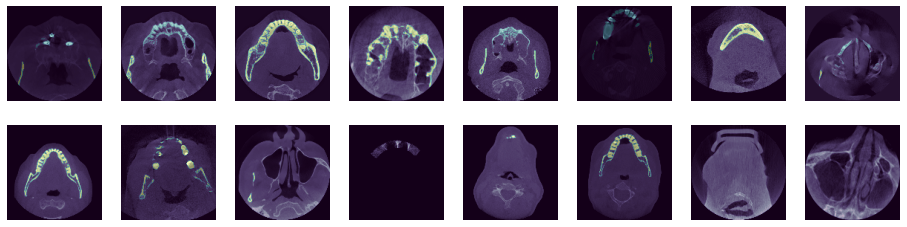

In [9]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

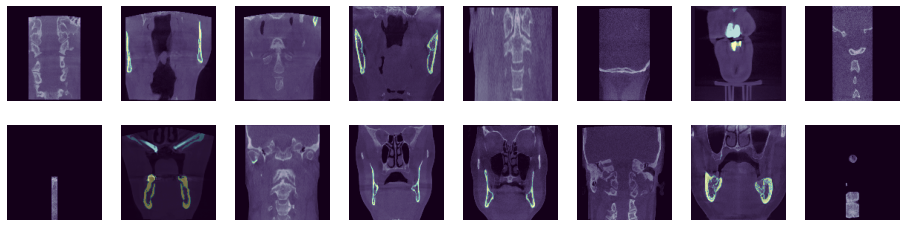

In [10]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

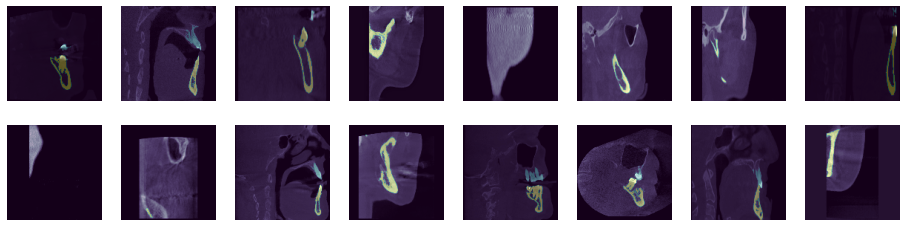

In [11]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

## Testing

Now you should run your trained model on the test dataset available below and report your results

In [12]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice
